In [463]:
import numpy as np
import pandas as pd
import hvplot.pandas
from finta import TA
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [464]:
# MODEL 1 Using Short/Long windows 50 / 100 
# Retrieve historical price data for the Stock
stock_name = "TSLA"
stock = yf.Ticker(stock_name)
history = stock.history(period="5y")
history2 = stock.history(period="5y")

# Set Initial Capital
initial_capital = float(100000)
stock_size = 100

# select column Close using function loc from the dataframe history
history = history.loc[:,['Close']]

# Assign windows size determine to Short / Long 
short_window = 50
long_window = 100

# Calculate SMAs 50/100 days average
history['SMA50'] = history['Close'].rolling(window=short_window).mean()
history['SMA100'] = history['Close'].rolling(window=long_window).mean()
history['Signal'] = 0

# Clean NaN values in the 'Close' column by dropping rows
history = history.dropna()

# Generate the trading signal 0 or 1,
# where 1 is when short-window (SMA50) is greater than the long (SMA 100)
# and 0 otherwise
history['Signal'][short_window:] = np.where(
    history['SMA50'][short_window:] > history['SMA100'][short_window:], 1, 0)

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
history['Entry/Exit'] = history['Signal'].diff()

In [465]:
# Model 1 Visualization
# Visualize exit position relative to close price
exit = history[history['Entry/Exit'] == -1]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = history[history['Entry/Exit'] == 1]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = history[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = history[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="Stock - SMA50, SMA100, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [466]:
# BACKTEST 1 Using 50/100 Short/Long Window

# Buy 100 share when the dual moving average crossover Signal is 1 (SMA50 cross SMA100 signals)
history['Position']= stock_size*history['Signal']
# Calculate the points in time at which a position should be taken, 1 or -1  Diff function shows when the signs change positions
history['Entry/Exit Position']=history['Position'].diff()
# Multiply share price by entry/exit positions and get the cumulatively sum
history["Stock Holdings"] = (
    history["Close"] * history["Entry/Exit Position"].cumsum()
)
# Subtract the initial capital by the stock holdings to get the amount of liquid cash in the stock
history["stock Cash"] = (
    initial_capital - (history["Close"] * history["Entry/Exit Position"]).cumsum()
)
# Get the total stock value by adding the cash amount by the stock holdings (or investments)
history["stock Total"] = (
    history["stock Cash"] + history["Stock Holdings"]
)
# Calculate the stock daily returns
history["stock daily returns"] = history["stock Total"].pct_change()
# Calculate the cumulative returns
history["stock cumulative returns"] = (
    1 + history["stock daily returns"]
).cumprod() - 1

In [467]:
# Visualize Exit, entry position relative to total stock Value
exit = history[history['Entry/Exit'] == -1]['stock Total'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Total Stock Value',
    width=1000,
    height=400)
# Visualize entry position relative to total stock value
entry = history[history['Entry/Exit'] == 1]['stock Total'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Total Stock Value',
    width=1000,
    height=400)
# Visualize the value of the total stock
total_stock_value = history[['stock Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Stock Value',
    xlabel='Date',
    width=1000,
    height=400)
# Overlay the plots
Stock_entry_exit_plot = total_stock_value * entry *exit
Stock_entry_exit_plot.opts(
    title='Stock Algorithm - Total Stock Value',
    yformatter='%.0f')


:Overlay
   .Curve.I                :Curve   [Date]   (stock Total)
   .Scatter.Stock_Total.I  :Scatter   [Date]   (stock Total)
   .Scatter.Stock_Total.II :Scatter   [Date]   (stock Total)

In [468]:
# BACK TEST 1 Risk and Reward RESULT
#Set Up Stock Level Risk by measuring
# Create a list that holds the columns name
metrics=[
    'Annualized Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio'
]
# Create a list that holds the column name
columns = ['Backtest 1']

# Initialize the DataFrame with index set to evaluation metrics and columns 
stock_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Calculate the Annualized return metric
stock_evaluation_df.loc['Annualized Return'] = (
    history['stock daily returns'].mean() * 252)

# Calculate the Cumulative returns metric
stock_evaluation_df.loc['Cumulative Returns'] = history['stock cumulative returns'][-1]

# Calculate the Annual volatility metric
stock_evaluation_df.loc['Annual Volatility'] = (
    history['stock daily returns'].std() * np.sqrt(252))

# Calculate the Sharpe ratio
stock_evaluation_df.loc['Sharpe Ratio'] = (
   history['stock daily returns'].mean() * 252) / (
    history['stock daily returns'].std() * np.sqrt(252))

# Calculate the Sortino ratio
# Create a DataFrame that contains the stock Daily Returns column
sortino_ratio_df = history[['stock daily returns']].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,'Downside Returns'] = 0

# Find stock Daily Returns values less than 0, 
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df['stock daily returns'] < 0, 
                     'Downside Returns'] = sortino_ratio_df['stock daily returns']**2

# Calculate the annualized return value
annualized_return = sortino_ratio_df['stock daily returns'].mean() * 252

# Calculate the annualized downside standard deviation value
downside_standard_deviation = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)

# Divide the annualized return value by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
stock_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
# Add new column Backtest1 with stock evaluation df data
Backtest1 = stock_evaluation_df
Backtest1

,Backtest 1
Annualized Return,0.059837
Cumulative Returns,0.298908
Annual Volatility,0.075813
Sharpe Ratio,0.789273
Sortino Ratio,1.157641


In [469]:
# MODEL 2  Using 25/50 Short/Long Window

# Retrieve historical price data 
history = stock.history(period="5y")

# Set Initial Capital
initial_capital = float(100000)
stock_size = 100

# select column Close using loc from the dataframe history
history=history.loc[:,['Close']]

# Assign windows size determine to Short / Long 
short_window = 25
long_window = 50

# Calculate SMAs 25/50 days average
history['SMA50'] = history['Close'].rolling(window=short_window).mean()
history['SMA100'] = history['Close'].rolling(window=long_window).mean()
history['Signal'] = 0

# Clean NaN values in the 'Close' column by dropping rows
history=history.dropna()

# Generate the trading signal 0 or 1,
# where 1 is when short-window (SMA50) is greater than the long (SMA 100)
# and 0 otherwise
history['Signal'][short_window:] = np.where(
    history['SMA50'][short_window:] > history['SMA100'][short_window:], 1, 0)

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
history['Entry/Exit'] = history['Signal'].diff()

In [470]:
# BACKTEST 2

# Buy 100 share when the dual moving average crossover Signal is 1 (SMA50 cross SMA100 signals)
history['Position']= stock_size*history['Signal']
# Calculate the points in time at which a position should be taken, 1 or -1  Diff function shows when the signs change positions
history['Entry/Exit Position']=history['Position'].diff()
# Multiply share price by entry/exit positions and get the cumulatively sum
history["Stock Holdings"] = (
    history["Close"] * history["Entry/Exit Position"].cumsum()
)
# Subtract the initial capital by the stock holdings to get the amount of liquid cash in the stock
history["stock Cash"] = (
    initial_capital - (history["Close"] * history["Entry/Exit Position"]).cumsum()
)
# Get the total stock value by adding the cash amount by the stock holdings (or investments)
history["stock Total"] = (
    history["stock Cash"] + history["Stock Holdings"]
)
# Calculate the stock daily returns
history["stock daily returns"] = history["stock Total"].pct_change()
# Calculate the cumulative returns
history["stock cumulative returns"] = (
    1 + history["stock daily returns"]
).cumprod() - 1

In [471]:
# Visualize Exit position relative to total stock Value
exit = history[history['Entry/Exit'] == -1]['stock Total'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Total Stock Value',
    width=1000,
    height=400)
# Visualize entry position relative to total stock value
entry = history[history['Entry/Exit'] == 1]['stock Total'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Total Stock Value',
    width=1000,
    height=400)
# Visualize the value of the total stock
total_stock_value = history[['stock Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Stock Value',
    xlabel='Date',
    width=1000,
    height=400)
# Overlay the plots
Stock_entry_exit_plot = total_stock_value * entry *exit
Stock_entry_exit_plot.opts(
    title='Stock Algorithm - Total Stock Value',
    yformatter='%.0f')

:Overlay
   .Curve.I                :Curve   [Date]   (stock Total)
   .Scatter.Stock_Total.I  :Scatter   [Date]   (stock Total)
   .Scatter.Stock_Total.II :Scatter   [Date]   (stock Total)

In [472]:
# BACKTEST 2 Risk / Reward RESULT
#Set Up Stock Level Risk by measuring
# Create a list that holds the columns name
metrics=[
    'Annualized Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio'
]
# Create a list that holds the column name
columns = ['Backtest 2']

# Initialize the DataFrame with index set to evaluation metrics and columns 
stock_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Calculate the Annualized return metric
stock_evaluation_df.loc['Annualized Return'] = (
    history['stock daily returns'].mean() * 252)

# Calculate the Cumulative returns metric
stock_evaluation_df.loc['Cumulative Returns'] = history['stock cumulative returns'][-1]

# Calculate the Annual volatility metric
stock_evaluation_df.loc['Annual Volatility'] = (
    history['stock daily returns'].std() * np.sqrt(252))

# Calculate the Sharpe ratio
stock_evaluation_df.loc['Sharpe Ratio'] = (
   history['stock daily returns'].mean() * 252) / (
    history['stock daily returns'].std() * np.sqrt(252))

# Calculate the Sortino ratio
# Create a DataFrame that contains the stock Daily Returns column
sortino_ratio_df = history[['stock daily returns']].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,'Downside Returns'] = 0

# Find stock Daily Returns values less than 0, 
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df['stock daily returns'] < 0, 
                     'Downside Returns'] = sortino_ratio_df['stock daily returns']**2

# Calculate the annualized return value
annualized_return = sortino_ratio_df['stock daily returns'].mean() * 252

# Calculate the annualized downside standard deviation value
downside_standard_deviation = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)

# Divide the annualized return value by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
stock_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
Backtest2 = stock_evaluation_df
Backtest2

,Backtest 2
Annualized Return,0.040075
Cumulative Returns,0.195535
Annual Volatility,0.074589
Sharpe Ratio,0.537279
Sortino Ratio,0.746391


In [474]:
# Using the original data frame for a VAMA model


In [475]:
# Define the window sizes for short and long VAMA
short_vama = 50
long_vama = 100

In [476]:
# Calculate short and long VAMA
history2["Short"] = TA.VAMA(history2, short_window)
history2["Long"] = TA.VAMA(history2, long_window)
history2.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Short,Long
Date,,,,,,,,,
2018-07-16 00:00:00-04:00,20.780666,21.010668,20.416668,20.673332,117280500,0.0,0.0,NaN,NaN
2018-07-17 00:00:00-04:00,20.587334,21.649332,20.566668,21.512667,104943000,0.0,0.0,NaN,NaN
2018-07-18 00:00:00-04:00,21.666668,21.700001,21.083332,21.590000,84363000,0.0,0.0,NaN,NaN
2018-07-19 00:00:00-04:00,21.088667,21.569332,20.934000,21.348667,88729500,0.0,0.0,NaN,NaN
2018-07-20 00:00:00-04:00,21.415333,21.549334,20.780666,20.905333,77433000,0.0,0.0,NaN,NaN


In [477]:
history2 = history2.dropna()

In [478]:
# Set the Signal column
history2["Signal"] = 0.0

In [479]:
# Generate trading signal
history2["Signal"][short_window:]=np.where(history2["Short"][short_window:]> history2["Long"][short_window:], 1.0, 0.0)
history2['Entry/Exit'] = history2['Signal'].diff()

C:\Users\miyak\AppData\Local\Temp\ipykernel_18988\2081573812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history2["Signal"][short_window:]=np.where(history2["Short"][short_window:]> history2["Long"][short_window:], 1.0, 0.0)


In [480]:
history2

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Short,Long,Signal,Entry/Exit
Date,,,,,,,,,,,
2018-12-03 00:00:00-05:00,24.000000,24.400000,23.466667,23.899332,124597500,0.0,0.0,22.983189,20.685822,0.0,NaN
2018-12-04 00:00:00-05:00,23.736668,24.578667,23.466667,23.980000,126928500,0.0,0.0,23.104044,20.765327,0.0,0.0
2018-12-06 00:00:00-05:00,23.733999,24.492001,23.384001,24.204000,117637500,0.0,0.0,23.225128,20.841293,0.0,0.0
2018-12-07 00:00:00-05:00,24.600000,25.299334,23.843332,23.864668,172668000,0.0,0.0,23.308186,20.931243,0.0,0.0
2018-12-10 00:00:00-05:00,24.000000,24.398666,23.541332,24.343332,99202500,0.0,0.0,23.376200,20.996540,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 00:00:00-04:00,276.470001,277.519989,265.100006,269.609985,119425400,0.0,0.0,252.563197,226.278112,1.0,0.0
2023-07-11 00:00:00-04:00,268.649994,270.899994,266.369995,269.790009,91972400,0.0,0.0,254.631694,227.767580,1.0,0.0
2023-07-12 00:00:00-04:00,276.329987,276.519989,271.459991,271.989990,95672100,0.0,0.0,256.576267,229.264118,1.0,0.0


In [481]:
entry = history2[history2["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=800,
    height=400
)

# Visualize exit position relative to close price
exit = history2[history2["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='red',
    marker='v',
    size=100,
    legend=False,
    ylabel='Price in $',
    width=800,
    height=400
)

# Visualize close price for the investment
price_plot = history2["Close"].hvplot.line(
    title='VAMA Entry/Exit Signals',
    line_color="blue",
    ylabel='Price in $',
    width=800,
    height=400
)

# Visualize moving average
moving_avgs=history2[["Short", "Long"]].hvplot(
    ylabel="Price in $",
    width=800,
    height=400
)

# Overlay plots
entry_exit_plot = price_plot * moving_avgs * entry * exit
entry_exit_plot

:Overlay
   .Curve.Close      :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [482]:
# BACKTEST VAMA Using 50/100 Volume Trade Data 

# Buy 100 share when the dual moving average crossover Signal is 1 (SMA50 cross SMA100 signals)
history2['Position']= stock_size*history2['Signal']
# Calculate the points in time at which a position should be taken, 1 or -1  Diff function shows when the signs change positions
history2['Entry/Exit Position']=history2['Position'].diff()
# Multiply share price by entry/exit positions and get the cumulatively sum
history2["Stock Holdings"] = (
    history2["Close"] * history2["Entry/Exit Position"].cumsum()
)
# Subtract the initial capital by the stock holdings to get the amount of liquid cash in the stock
history2["stock Cash"] = (
    initial_capital - (history2["Close"] * history2["Entry/Exit Position"]).cumsum()
)
# Get the total stock value by adding the cash amount by the stock holdings (or investments)
history2["stock Total"] = (
    history2["stock Cash"] + history2["Stock Holdings"]
)
# Calculate the stock daily returns
history2["stock daily returns"] = history2["stock Total"].pct_change()
# Calculate the cumulative returns
history2["stock cumulative returns"] = (
    1 + history2["stock daily returns"]
).cumprod() - 1

In [483]:
# Visualize Exit position relative to total stock Value
exit = history2[history2['Entry/Exit'] == -1]['stock Total'].hvplot.scatter(
    color='red',
    marker='v',
    legend=False,
    ylabel='Total Stock Value',
    width=1000,
    height=400)
# Visualize entry position relative to total stock value
entry = history2[history2['Entry/Exit'] == 1]['stock Total'].hvplot.scatter(
    color='green',
    marker='^',
    ylabel='Total Stock Value',
    width=1000,
    height=400)
# Visualize the value of the total stock
total_stock_value = history2[['stock Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Stock Value',
    xlabel='Date',
    width=1000,
    height=400)
# Overlay the plots
Stock_entry_exit_plot = total_stock_value * entry *exit
Stock_entry_exit_plot.opts(
    title='Stock Algorithm - Total Stock Value',
    yformatter='%.0f')

:Overlay
   .Curve.I                :Curve   [Date]   (stock Total)
   .Scatter.Stock_Total.I  :Scatter   [Date]   (stock Total)
   .Scatter.Stock_Total.II :Scatter   [Date]   (stock Total)

In [484]:
# BACK TEST  Risk and Reward RESULT
#Set Up Stock Level Risk by measuring
# Create a list that holds the columns name
metrics_vama=[
    'Annualized Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio'
]
# Create a list that holds the column name
columns = ['Backtest VAMA']

# Initialize the DataFrame with index set to evaluation metrics and columns 
stock_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Calculate the Annualized return metric
stock_evaluation_df.loc['Annualized Return'] = (
    history2['stock daily returns'].mean() * 252)

# Calculate the Cumulative returns metric
stock_evaluation_df.loc['Cumulative Returns'] = history2['stock cumulative returns'][-1]

# Calculate the Annual volatility metric
stock_evaluation_df.loc['Annual Volatility'] = (
    history2['stock daily returns'].std() * np.sqrt(252))

# Calculate the Sharpe ratio
stock_evaluation_df.loc['Sharpe Ratio'] = (
   history2['stock daily returns'].mean() * 252) / (
    history2['stock daily returns'].std() * np.sqrt(252))

# Calculate the Sortino ratio
# Create a DataFrame that contains the stock Daily Returns column
sortino_ratio_df = history2[['stock daily returns']].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,'Downside Returns'] = 0

# Find stock Daily Returns values less than 0, 
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df['stock daily returns'] < 0, 
                     'Downside Returns'] = sortino_ratio_df['stock daily returns']**2

# Calculate the annualized return value
annualized_return = sortino_ratio_df['stock daily returns'].mean() * 252

# Calculate the annualized downside standard deviation value
downside_standard_deviation = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)

# Divide the annualized return value by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
stock_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
# Add new column Backtest1 with stock evaluation df data
Backtest_vama = stock_evaluation_df
Backtest_vama

,Backtest VAMA
Annualized Return,0.027059
Cumulative Returns,0.116698
Annual Volatility,0.077875
Sharpe Ratio,0.347462
Sortino Ratio,0.473362


In [485]:
# Put side by side Backtest Results
Compare_test = pd.concat([Backtest1, Backtest2, Backtest_vama], axis=1)
Compare_test

,Backtest 1,Backtest 2,Backtest VAMA
Annualized Return,0.059837,0.040075,0.027059
Cumulative Returns,0.298908,0.195535,0.116698
Annual Volatility,0.075813,0.074589,0.077875
Sharpe Ratio,0.789273,0.537279,0.347462
Sortino Ratio,1.157641,0.746391,0.473362


In [94]:
import yfinance as yf
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
portfolio_name = ["AAPL", "MSFT", "GOOGL", "LCID", "TSLA"]

In [95]:
# Get the data on these tickers
AAPL = yf.Ticker(portfolio_name[0])
MSFT = yf.Ticker(portfolio_name[1])
GOOGL = yf.Ticker(portfolio_name[2])
LCID = yf.Ticker(portfolio_name[3])
TSLA = yf.Ticker(portfolio_name[4])

In [96]:
# Get the historical prices for the tickers
AAPL_df = AAPL.history(period="1d", start='2022-6-1', end='2023-6-1')
MSFT_df = MSFT.history(period="1d", start='2022-6-1', end='2023-6-1')
GOOGL_df = GOOGL.history(period="1d", start='2022-6-1', end='2023-6-1')
LCID_df = LCID.history(period="1d", start='2022-6-1', end='2023-6-1')
TSLA_df = TSLA.history(period="1d", start='2022-6-1', end='2023-6-1')

In [97]:
# Save the close columns of each stock into new variables
AAPL = AAPL_df['Close']
MSFT = MSFT_df['Close']
GOOGL = GOOGL_df['Close']
LCID = LCID_df['Close']
TSLA = TSLA_df['Close']

In [98]:
# Concatenate all stocks close columns into one data frame
stock_df = pd.concat([AAPL, MSFT, GOOGL, LCID, TSLA], axis='columns', join='inner')
# Rename the data frame columns with their corresponding tickers symbols
stock_df.columns = ["AAPL", 'MSFT', 'GOOGL', 'LCID', 'TSLA']
stock_df.head()

,AAPL,MSFT,GOOGL,LCID,TSLA
Date,,,,,
2022-06-01 00:00:00-04:00,147.827301,269.811920,113.891998,19.500000,246.789993
2022-06-02 00:00:00-04:00,150.312454,271.951233,117.622498,19.959999,258.333344
2022-06-03 00:00:00-04:00,144.517059,267.434937,114.541000,18.670000,234.516663
2022-06-06 00:00:00-04:00,145.272552,266.177063,116.820503,19.150000,238.279999
2022-06-07 00:00:00-04:00,147.827301,269.891174,117.149498,18.959999,238.886673


In [99]:
# Calculate SMA50 and SMA100 for each stock in the portfolio
stock_df['SMA50_AAPL'] = stock_df['AAPL'].rolling(window=50).mean()
stock_df['SMA100_AAPL'] = stock_df['AAPL'].rolling(window=100).mean()
stock_df['SMA50_MSFT'] = stock_df['MSFT'].rolling(window=50).mean()
stock_df['SMA100_MSFT'] = stock_df['MSFT'].rolling(window=100).mean()
stock_df['SMA50_GOOGL'] = stock_df['GOOGL'].rolling(window=50).mean()
stock_df['SMA100_GOOGL'] = stock_df['GOOGL'].rolling(window=100).mean()
stock_df['SMA50_LCID'] = stock_df['LCID'].rolling(window=50).mean()
stock_df['SMA100_LCID'] = stock_df['LCID'].rolling(window=100).mean()
stock_df['SMA50_TSLA'] = stock_df['TSLA'].rolling(window=50).mean()
stock_df['SMA100_TSLA'] = stock_df['TSLA'].rolling(window=100).mean()
# Display the updated portfolio DataFrame
stock_df.tail()

,AAPL,MSFT,GOOGL,LCID,TSLA,SMA50_AAPL,SMA100_AAPL,SMA50_MSFT,SMA100_MSFT,SMA50_GOOGL,SMA100_GOOGL,SMA50_LCID,SMA100_LCID,SMA50_TSLA,SMA100_TSLA
Date,,,,,,,,,,,,,,,
2023-05-24 00:00:00-04:00,171.839996,313.850006,120.900002,7.49,182.899994,165.655747,154.834835,293.183603,270.657146,107.9342,101.0495,7.6088,8.35885,178.478799,173.8585
2023-05-25 00:00:00-04:00,172.990005,325.920013,123.480003,7.61,184.470001,166.059973,155.269208,294.404783,271.529355,108.4816,101.4020,7.6130,8.36665,178.559200,174.4714
2023-05-26 00:00:00-04:00,175.429993,332.890015,124.610001,7.87,193.169998,166.455878,155.776440,295.550633,272.473654,108.9674,101.7569,7.6138,8.38365,178.739999,175.3221
2023-05-30 00:00:00-04:00,177.300003,331.209991,123.669998,7.71,201.160004,166.906160,156.289509,296.598423,273.505463,109.4084,102.1128,7.6142,8.39595,179.160599,176.1973
2023-05-31 00:00:00-04:00,177.250000,328.390015,122.870003,7.76,203.929993,167.307509,156.815439,297.733500,274.576655,109.8414,102.4795,7.6154,8.41105,179.574199,177.1332


In [100]:
# Create a new column named "signal" and set all values to 0
stock_df['signal'] = 0

# Set the buy signals  Set the sell signals
stock_df.loc[stock_df['SMA50_AAPL'] > stock_df['SMA100_AAPL'], 'signal'] = 1
stock_df.loc[stock_df['SMA50_AAPL'] < stock_df['SMA100_AAPL'], 'signal'] = -1
stock_df.loc[stock_df['SMA50_MSFT'] > stock_df['SMA100_MSFT'], 'signal'] = 1
stock_df.loc[stock_df['SMA50_MSFT'] < stock_df['SMA100_MSFT'], 'signal'] = -1
stock_df.loc[stock_df['SMA50_GOOGL'] > stock_df['SMA100_GOOGL'], 'signal'] = 1
stock_df.loc[stock_df['SMA50_GOOGL'] < stock_df['SMA100_GOOGL'], 'signal'] = -1
stock_df.loc[stock_df['SMA50_LCID'] > stock_df['SMA100_LCID'], 'signal'] = 1
stock_df.loc[stock_df['SMA50_LCID'] < stock_df['SMA100_LCID'], 'signal'] = -1
stock_df.loc[stock_df['SMA50_TSLA'] > stock_df['SMA100_TSLA'], 'signal'] = 1
stock_df.loc[stock_df['SMA50_TSLA'] < stock_df['SMA100_TSLA'], 'signal'] = -1

# Drop all Nan values from stock_df
stock_df=stock_df.dropna()

# Display the updated portfolio DataFrame
print(stock_df)

                                 AAPL        MSFT       GOOGL   LCID  \
Date                                                                   
2022-10-21 00:00:00-04:00  146.599197  240.311035  101.129997  13.31   
2022-10-24 00:00:00-04:00  148.769257  245.402695  102.519997  12.80   
2022-10-25 00:00:00-04:00  151.646088  248.787216  104.480003  13.92   
2022-10-26 00:00:00-04:00  148.669724  229.591721   94.930000  13.91   
2022-10-27 00:00:00-04:00  144.140442  225.055847   92.220001  13.79   
...                               ...         ...         ...    ...   
2023-05-24 00:00:00-04:00  171.839996  313.850006  120.900002   7.49   
2023-05-25 00:00:00-04:00  172.990005  325.920013  123.480003   7.61   
2023-05-26 00:00:00-04:00  175.429993  332.890015  124.610001   7.87   
2023-05-30 00:00:00-04:00  177.300003  331.209991  123.669998   7.71   
2023-05-31 00:00:00-04:00  177.250000  328.390015  122.870003   7.76   

                                 TSLA  SMA50_AAPL  SMA100_AAPL 

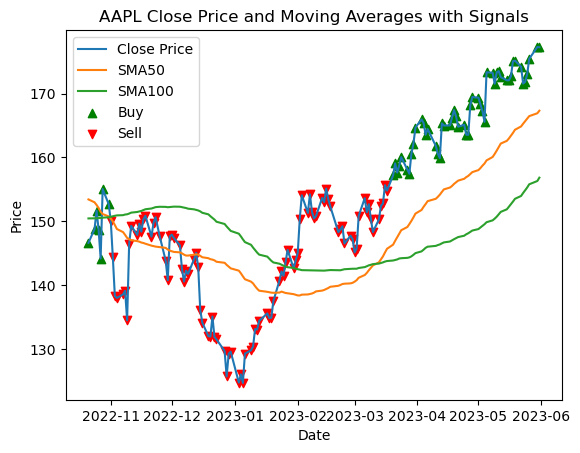

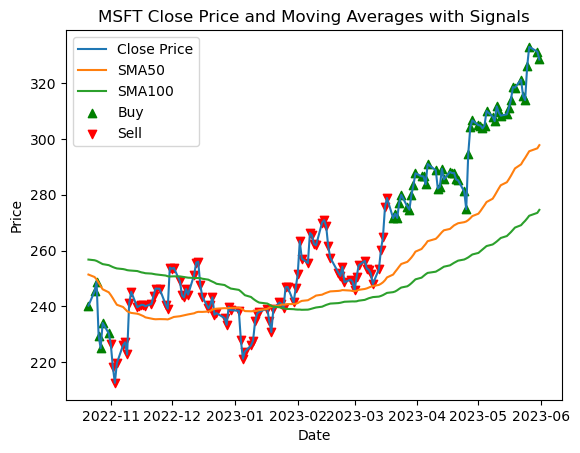

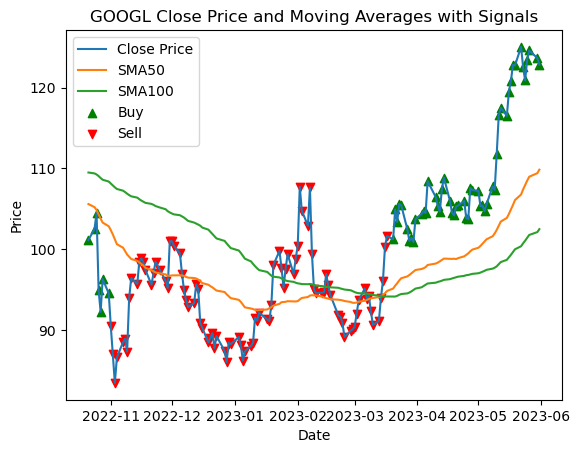

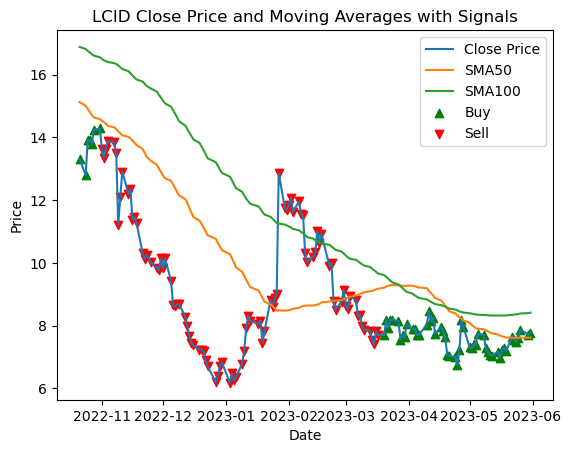

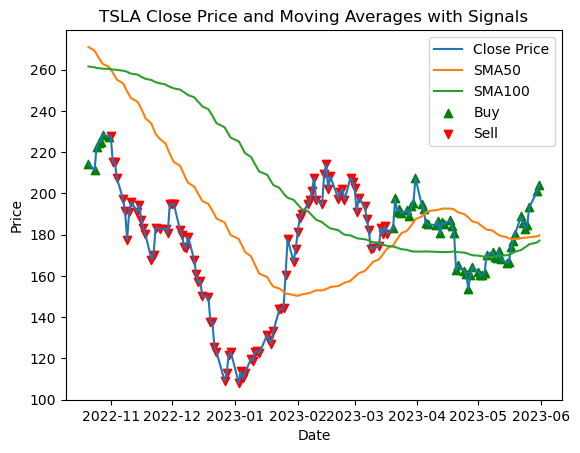

KeyError: 'SMA50_SMA50_AAPL'

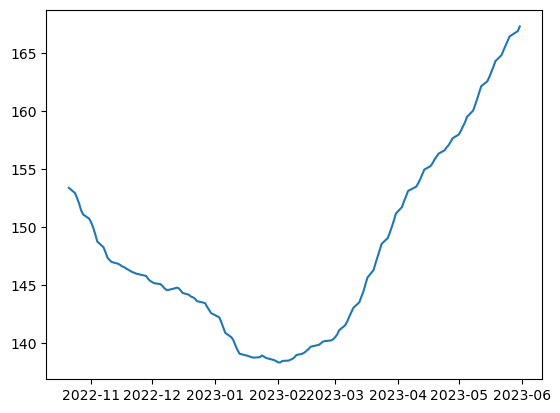

In [101]:
# Get the list of stocks (column names) in stock_df
stocks = stock_df.columns[:-2]  # Exclude SMA50 and SMA100 columns

# Iterate over each stock and create a separate plot
for stock in stocks:
    # Create a new figure and axis for each stock
    fig, ax = plt.subplots()

    # Plot the close price line
    ax.plot(stock_df.index, stock_df[stock], label='Close Price')

    # Get the corresponding SMA50 and SMA100 column names for the current stock
    sma50_col = f'SMA50_{stock}'
    sma100_col = f'SMA100_{stock}'

    # Plot the SMA50 and SMA100
    ax.plot(stock_df.index, stock_df[sma50_col], label='SMA50')
    ax.plot(stock_df.index, stock_df[sma100_col], label='SMA100')

    # Get the buy and sell signals for the current stock
    buy_signals = stock_df[stock_df['signal'] == 1]
    sell_signals = stock_df[stock_df['signal'] == -1]

    # Plot the buy signals as green triangles
    ax.scatter(buy_signals.index, buy_signals[stock], marker='^', color='green', label='Buy')

    # Plot the sell signals as red triangles
    ax.scatter(sell_signals.index, sell_signals[stock], marker='v', color='red', label='Sell')

    # Set the plot title and labels
    ax.set_title(f'{stock} Close Price and Moving Averages with Signals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()





In [ ]:
# Bollinger Model
# Calculate the 20-day moving average
history['SMA20'] = history['Close'].rolling(window=20).mean()
# Calculate the standard deviation of the price over the 20-day period
history['STD'] = history['Close'].rolling(window=20).std()
# Calculate the upper and lower Bollinger Bands
history['Upper Band'] = history['SMA20'] + (2 * history['STD'])
history['Lower Band'] = history['SMA20'] - (2 * history['STD'])
# Plotting the Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(history['Close'], label='Close')
plt.plot(history['SMA20'], label='SMA20')
plt.plot(history['Upper Band'], label='Upper Band')
plt.plot(history['Lower Band'], label='Lower Band')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

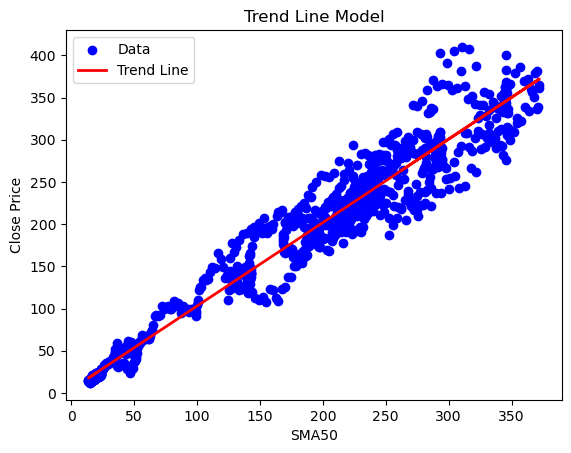

In [102]:
# Trend Line
# Reset the index of the DataFrame
history_reset = history.reset_index()

# Import SimpleImputer from scikit-learn
from sklearn.impute import SimpleImputer

# Create an instance of the imputer with the desired strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputation to the 'SMA50' column in the 'history_reset' DataFrame
history_reset['SMA50'] = imputer.fit_transform(history_reset[['SMA50']])
#Clean the Data using dropna to remove NaN
history_reset.dropna(inplace=True)

# Assuming your DataFrame variable is named 'history_reset' and missing values are handled
x = history_reset['SMA50'].values.reshape(-1, 1)
y = history_reset['Close'].values

# Create an instance of the linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

# Predict the y values based on the fitted model
y_pred = model.predict(x)

# Plot the data points and the trend line
plt.scatter(x, y, color='blue', label='Data')
plt.plot(x, y_pred, color='red', linewidth=2, label='Trend Line')
plt.xlabel('SMA50')
plt.ylabel('Close Price')
plt.title('Trend Line Model')
plt.legend()
plt.show()

In [103]:
# Check the last value of the Signal and assign a current Trade Signal
signal = history['Signal'].iloc[-1]

if signal == 1:
    message = "It's time to buy."
elif signal == -1:
    message = "It's time to sell."
else:
    message = "Hold your position."

print("Trading Signal:", message)

Trading Signal: It's time to buy.
